In [127]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tf_agents.agents.dqn import dqn_agent


import constant as const
import functools
from collections import defaultdict

from typing import Callable, Dict, List, Any, Optional, TypeVar

from tf_agents.replay_buffers import reverb_replay_buffer, tf_uniform_replay_buffer
from tf_agents.replay_buffers import reverb_utils

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts, trajectory
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.utils import common
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver, py_tf_eager_policy
import tf_agents
from tf_agents.drivers import py_driver


from tf_agents.specs import tensor_spec

from tf_agents.networks import sequential



T = TypeVar("T")


In [128]:
def define_rl_environment() -> TFEnvironment:
    env = movielens_py_environment.MovieLensPyEnvironment(
    const.DATA_PATH, const.RANK_K, 2, num_movies=const.NUM_ACTIONS, csv_delimiter="\t")
    environment = tf_py_environment.TFPyEnvironment(env)
    return environment

In [129]:
def define_rl_metric(environment: TFEnvironment) -> List[Any]:
    optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment,
    environment=environment)
    regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
    print(regret_metric.result())
    metrics = [regret_metric]
    return metrics

In [130]:
env = define_rl_environment()
metric = define_rl_metric(env)

tf.Tensor(0.0, shape=(), dtype=float32)


In [131]:
print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward spec')
print(env.reward_spec())

print('Action spec')
print(env.action_spec())

Observation Spec:
TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
Reward spec
TensorSpec(shape=(), dtype=tf.float32, name='reward')
Action spec
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(19))


In [132]:
print('action_spec:', env.action_spec())
print('time_step_spec.observation:', env.time_step_spec().observation)
print('time_step_spec.step_type:', env.time_step_spec().step_type)
print('time_step_spec.discount:', env.time_step_spec().discount)
print('time_step_spec.reward:', env.time_step_spec().reward)

action_spec: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(19))
time_step_spec.observation: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
time_step_spec.step_type: TensorSpec(shape=(), dtype=tf.int32, name='step_type')
time_step_spec.discount: BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))
time_step_spec.reward: TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [165]:
# Try tensorflow Deep Q Network tutorial

fc_layer_params = (60, 40)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [166]:
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [135]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last()[0]:
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes

  return avg_return.numpy()[0]

In [136]:
compute_avg_return(env, agent.policy)

-5.154424e-15

In [137]:
# We need to add another dimension here because the agent expects the
# trajectory of shape [batch_size, time, ...], but in this tutorial we assume
# that both batch size and time are 1. Hence all the expand_dims.

def trajectory_for_bandit(initial_step, action_step, final_step):
  return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                               action=tf.expand_dims(action_step.action, 0),
                               policy_info=action_step.info,
                               reward=tf.expand_dims(final_step.reward, 0),
                               discount=tf.expand_dims(final_step.discount, 0),
                               step_type=tf.expand_dims(initial_step.step_type, 0),
                               next_step_type=tf.expand_dims(final_step.step_type, 0))

In [138]:
# step = env.reset()
# for _ in range(10):
#     action_step = agent.collect_policy.action(step)
#     next_step = env.step(action_step.action)
#     experience = trajectory_for_bandit(step, action_step, next_step)
#     print(experience)
#     print("action taken", agent.policy.action(step))
#     print("optimal action", env.compute_optimal_action())
#     agent.train(experience)
#     step = next_step

tf.Tensor(0.0, shape=(), dtype=float32)


Text(0.5, 0, 'Number of Iterations')

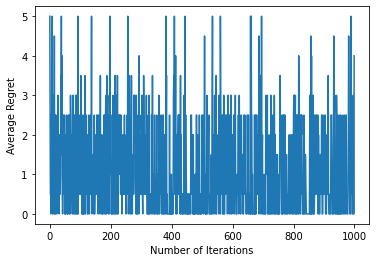

In [171]:
regret_metric = define_rl_metric(env)[0]

num_iterations = 1000 # @param
steps_per_loop = 2 # @param
batch_size = 2

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')